<a href="https://colab.research.google.com/github/devadharshini-162/Pulsar-Detection/blob/main/PULSAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, Attention, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

**Load Data**

In [ ]:
import pandas as pd
file_path = '/content/drive/MyDrive/HTRU_2 + Synthetic Dataset.csv'
data = pd.read_csv(file_path, header=None)

columns = ["Mean_IP", "Std_IP", "Kurtosis_IP", "Skewness_IP", "Mean_DM", "Std_DM", "Kurtosis_DM", "Skewness_DM", "Class"]
data.columns = columns

In [ ]:
data.head()

,Mean_IP,Std_IP,Kurtosis_IP,Skewness_IP,Mean_DM,Std_DM,Kurtosis_DM,Skewness_DM,Class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


**Separate Features and Target**

In [ ]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

**Visualize Class Distribution**

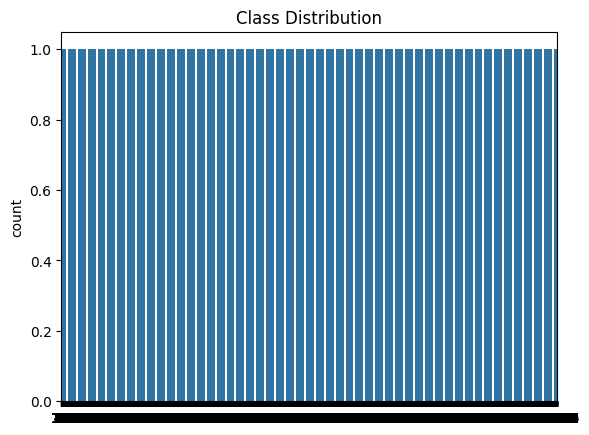

In [ ]:
sns.countplot(y)
plt.title("Class Distribution")
plt.show()

**Split Dataset**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

**Apply SMOTE for Oversampling**

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


**Normalize the Data**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test = scaler.transform(X_test)

**Reshape for CNN-LSTM Input**

In [ ]:
X_resampled = X_resampled.reshape(X_resampled.shape[0], X_resampled.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

**Attention layers**

In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.attention_weights = None  # Initialize attention weights

    def build(self, input_shape):
        # Create attention weight variable here
        self.attention_weights = self.add_weight(shape=(input_shape[-1], 1),
                                                initializer='random_normal',
                                                trainable=True,
                                                name='attention_weights')
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        # Compute attention scores
        attention_scores = K.tanh(K.dot(inputs, self.attention_weights))  # Use the defined weights
        attention_weights = K.softmax(attention_scores, axis=1)
        # Apply attention weights
        context_vector = attention_weights * inputs
        context_vector = K.sum(context_vector, axis=1)  # Summarize over time_steps
        return context_vector

**Build CNN-LSTM Model**

In [ ]:
input_layer = Input(shape=(X_resampled.shape[1], 1))

# CNN layers
x = Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.2)(x)

# LSTM layer
x = LSTM(50, return_sequences=True)(x)
x = Dropout(0.2)(x)

# Attention layer
x = Attention()(x)  # Apply the custom attention layer

# Fully connected layers
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation='sigmoid')(x)

# Model definition
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

**Model summary**

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 8, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 6, 32)               │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 3, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 3, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 3, 50)               │          16,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 3, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_2 (Attention)              │ (None, 50)                  │              50 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,107 (78.54 KB)

 Trainable params: 20,107 (78.54 KB)

 Non-trainable params: 0 (0.00 B)

**Callbacks**

In [ ]:
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

**Train the Model**

In [ ]:
history = model.fit(X_resampled, y_resampled,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    callbacks=[checkpoint, early_stop])

Epoch 1/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8579 - loss: 0.3422 - val_accuracy: 0.9250 - val_loss: 0.2103
Epoch 2/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9556 - loss: 0.1444 - val_accuracy: 0.9272 - val_loss: 0.1797
Epoch 3/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9568 - loss: 0.1381 - val_accuracy: 0.9229 - val_loss: 0.2236
Epoch 4/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9577 - loss: 0.1382 - val_accuracy: 0.9323 - val_loss: 0.1900
Epoch 5/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9587 - loss: 0.1331 - val_accuracy: 0.9220 - val_loss: 0.2190
Epoch 6/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9584 - loss: 0.1266 - val_accuracy: 0.9360 - val_loss: 0.1631
Epoch 7/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9608 - loss: 0.1285 - val_accuracy: 0.9339 - val_loss: 0.1866
Epoch 8/50
651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9616 - loss: 0.1209 - val_accuracy: 0.

**Evaluate the Model**

In [ ]:
y_pred = model.predict(X_test).ravel()
y_pred_binary = (y_pred > 0.5).astype(int)

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


**Classification Report**

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3252
           1       0.86      0.95      0.90       528

    accuracy                           0.97      3780
   macro avg       0.93      0.96      0.94      3780
weighted avg       0.97      0.97      0.97      3780



**Confusion Matrix**

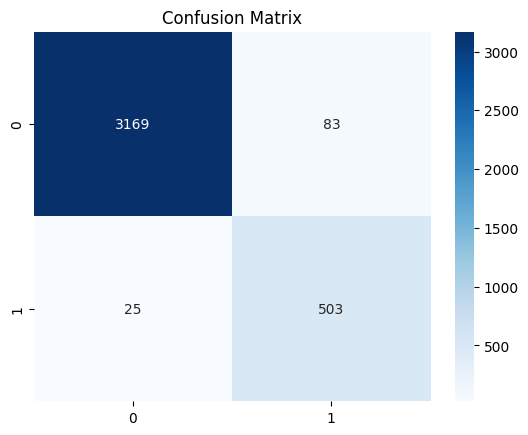

In [ ]:
cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

**AUC-ROC Curve**

AUC-ROC: 0.9873


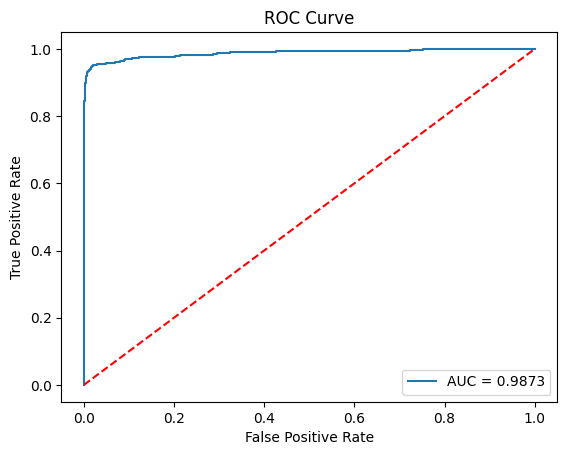

In [ ]:
auc = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC: {auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

**Save the Model**

In [ ]:
model.save('pulsar_cnn_lstm_attention_model.keras')

**Visualize Training History**

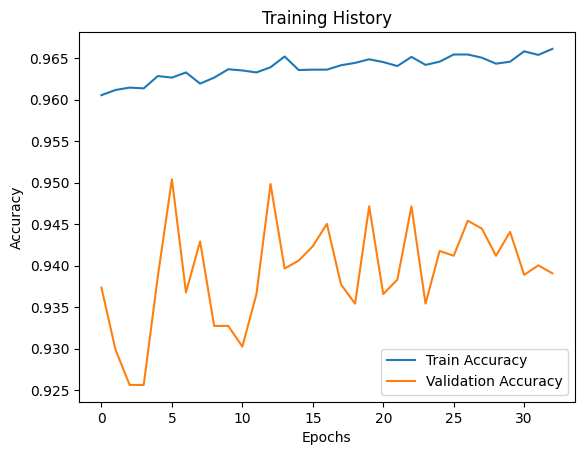

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training History')
plt.legend()
plt.show()